# GTD2 notebook

Spark python könyvtár importálása, majd a spark környezet felállítása

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.mllib.stat import Statistics

sc = pyspark.SparkContext()

Adatok betöltése, RDD objektumk létrehizása, külön választjuk az oszlopokat

In [2]:
from pyspark.sql import Row
raw = sc.textFile("globalterrorismdb_0617dist.txt")
data = raw.map(lambda x: x.split('\t'))

# Saját függvény, amely az adatnak az oszlop indexét adja vissza az oszlopnév alapján
def getIndexByKey(key):
    return data.take(1)[0].index(key)

## 1. EDA

incidents_in_countries-ba eltároljuk, hogy mennyi az összes rekord egy adott országra nézve

Várható kimenet:

országnév | eset db
--------- | -------
Japan | 401
Uruguay | 76
... | ...

Majd az első 5 legtöbb rekordot tartalmazó országot megjelenítjük


In [3]:
country_txt = getIndexByKey('country_txt')
incidents_in_countries = data.map(lambda x: (x[country_txt], 1)).reduceByKey(lambda a,b: a+b)
incidents_in_countries = incidents_in_countries.map(lambda x: (x[1], x[0])).sortByKey(0)
incidents_in_countries.take(3)

[(22130, 'Iraq'), (13634, 'Pakistan'), (11306, 'Afghanistan')]

In [4]:
import pandas as pd

iyear = getIndexByKey('iyear')
rdd_years = data.map(lambda x: (x[iyear], 1))\
                .reduceByKey(lambda a, b: a+b)\
                .filter(lambda x: x[0]!='iyear')\
                .sortByKey(1)

years = rdd_years.collect()
df_years = pd.DataFrame.from_records(years, columns = ('year', 'count')).apply(pd.to_numeric)

In [82]:
import numpy as np
summary_year = Statistics.colStats(rdd_years)

3703.260869565217

In [5]:
import pandas as pd

region = getIndexByKey('region')
nkill = getIndexByKey('nkill')
rdd_country_kill = data.map(lambda x: (x[region], x[nkill]))\
                       .reduceByKey(lambda a, b: a+b)\
                       .filter(lambda x: x[0]!='region')\
                       .sortByKey(1)

country_kill = rdd_country_kill.collect()
df_country_kill = pd.DataFrame.from_records(country_kill, columns = ('region', 'kills'))
df_country_kill

,region,kills
0,1,0000000000000000000000000000000000000000000000...
1,10,0000000100100000000000000000000000000300010010...
2,11,1001003201200100271000001000021000000201001013...
3,12,0001002000002000010100001010000000000000010000...
4,2,1100100000000000000000000002000111903120100101...
5,3,0000000101010100000010100200000000000000100100...
6,4,0250001000020111000000000000000001000000003000...
7,5,1000123610000020108110100003210000800131637000...
8,6,1000041100010014361110004100211111501133240131...
9,7,0200233012472300020271500032035000114040030031...


## 2. Vizualizáiók 
### 2.1 Terrortámadások denzitása

Az alábbi vizualizációs blokk az összes terrorcselekményt ábrázolja a hosszúsági és szélességi adatok alapján.
A vizualizációhoz elsősorban a *datashader* könyvtárat használjuk. A codebook alapján, a hosszúsági és szélességi adatok WGS84-es formátumba vannak tárolva, viszont ahhoz, hogy megfelelően tudjuk ábrázolni a pontokat, WebMercator formátumba kell  projektálni a meglévő hosszúsági és szélességi adatokat. Ehhez a *pyproj* nevű könyvtárat használjuk. Ehhez egy-egy  függvényt (*toWebMLon* és *toWebMLat*) definiáltunk, ami megvalósítja a megfelelő projekciókat. A pozíciókat a *pandas* könyvtár segítségével egy dataframe-be tároljuk, amit feltudunk használni a vizualizációhoz. Az ábrán fekete alapra egy 
"hőtérkép"-hez hasonló eredményt várunk, vagyis adott térségben lévő színfoltok fogják jellemezni a terror cselekmények helybeli sűrűségét.


In [6]:
from pyproj import Proj, transform

# long/lat. adatok Web mercator formátumba konvertálásához
def toWebMLon(lon):
    loc = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), lon, 0)
    return loc[0]

def toWebMLat(lat):
    loc = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), 0, lat)
    return loc[1]

def toWebM(pos):
    return transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), pos[0], pos[1])

# indexek
longitude = getIndexByKey('longitude')
latitude = getIndexByKey('latitude')

points = data.map(lambda x: (x[longitude], x[latitude])).collect()

# dataframe alakítás
locations = pd.DataFrame.from_records(points[1:], columns = points[0]).replace({',': '.'}, regex=True)
locations = locations.apply(pd.to_numeric, errors='coerce').dropna()

locations['longitude'] = locations['longitude'].apply(toWebMLon)
locations['latitude'] = locations['latitude'].apply(toWebMLat)

In [7]:
import datashader as ds
import datashader.glyphs
import datashader.transfer_functions as tf

x_range = (locations['longitude'].min(), locations['longitude'].max())
y_range = (locations['latitude'].min(), locations['latitude'].max())

plot_width  = int(1000) # Minnél nagyobb, jobb a felbontás, akár országon belüli eloszlás vizsgálatához
plot_height = int(plot_width*7.0/12)

cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, x_range=x_range, y_range=y_range)

agg = cvs.points(locations, 'longitude', 'latitude') 

/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


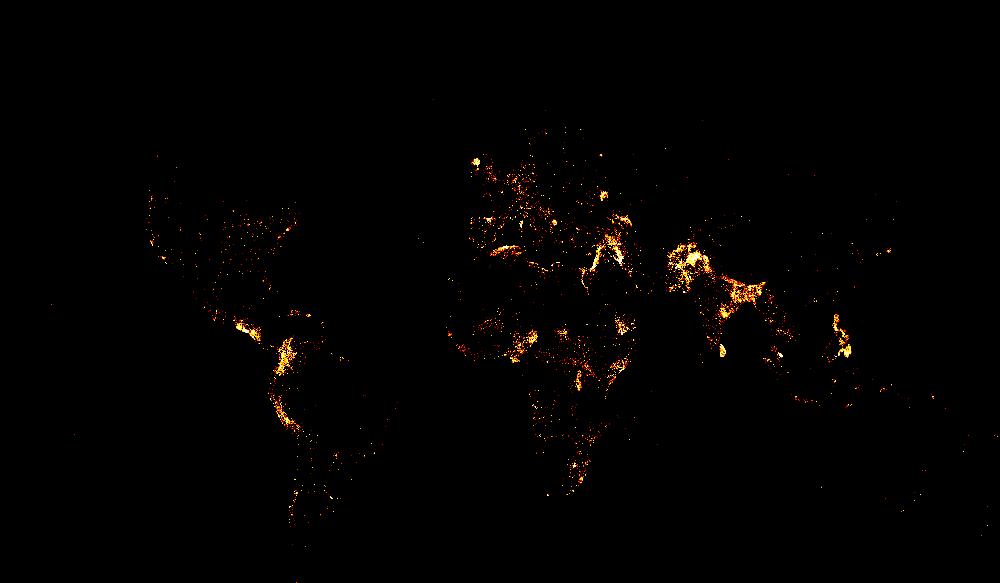

In [8]:
from functools import partial
from datashader.utils import export_image
from matplotlib.cm import hot

background = "black"
export = partial(export_image, background = background, export_path="export")

export(tf.shade(agg, cmap = hot, how='eq_hist'), "gtd_on_map")

### 2.2 Terrorcselekmények időbeli trendje
Az alábbi vizualizációs blokk egy egyszerű idősor diagram, amely ábrázolja, hogy egy évben mennyi terrorcselekmény történt.

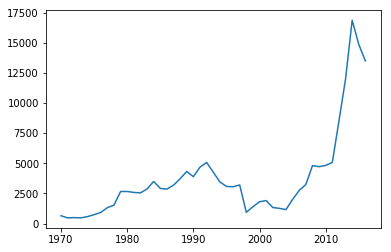

In [9]:
import matplotlib.pyplot as plt

plt.plot(df_years['year'], df_years['count'])
plt.show()